In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tweepy
import folium
import re
from textblob import TextBlob
import geopandas as gpd
from IPython.display import display

%matplotlib inline

In [2]:
CONSUMER_KEY    = '...'
CONSUMER_SECRET = '...'

ACCESS_TOKEN  = '....'
ACCESS_SECRET = '...'

# API's setup:
def twitter_setup():
    """
    Utility function to setup the Twitter's API
    with our access keys provided.
    """
    # Authentication and access using keys:
    auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
    auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)
    
    # Return API with authentication:
    api = tweepy.API(auth)
    return api

In [3]:
# #create an extractor object:
# extractor = twitter_setup()

# #create a tweet list:
# tweets = extractor.user_timeline(screen_name="elonmusk", count=200)
# print("Number of tweets extracted: {}.\n".format(len(tweets)))

### Instead of looking for tweets from one person i am going to look for tweets about the topic of my project, Solar Energy, in the location of my project, California. More specificly, here i am going to extract the tweets with the geocode in Los Angeles and a radius of 10KM

In [4]:
extractor = twitter_setup()

tweets = extractor.search("solar power", geocode='34.0522342,-118.2436849,10km', lang= 'en', count=200)
print("Number of tweets extracted: {}.\n".format(len(tweets)))

Number of tweets extracted: 100.



#### we can only get 100 tweets each time, to get more tweets we need to pick the ID of the last one and retrieve the tweets with a lower ID and append to our list

In [5]:
tweets2 = extractor.search("solar power", geocode='34.0522342,-118.2436849,10km', lang= 'en',count=100, max_id=tweets[-1].id-1)
tweets.extend(tweets2)
print("Number of tweets extracted: {}.\n".format(len(tweets2)))
print("Number of tweets: {}.\n".format(len(tweets)))

Number of tweets extracted: 100.

Number of tweets: 200.



In [6]:
tweets[0].text

'Generate Over 12x the power of regular #Solar #Panels! https://t.co/dRglAs0wRy #Heat #Power, #Free #Energy'

In [7]:
print(dir(tweets[0]))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_api', '_json', 'author', 'contributors', 'coordinates', 'created_at', 'destroy', 'entities', 'favorite', 'favorite_count', 'favorited', 'geo', 'id', 'id_str', 'in_reply_to_screen_name', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'is_quote_status', 'lang', 'metadata', 'parse', 'parse_list', 'place', 'possibly_sensitive', 'retweet', 'retweet_count', 'retweeted', 'retweets', 'source', 'source_url', 'text', 'truncated', 'user']


In [8]:
df = pd.DataFrame()
df['tweet'] = [tweet.text for tweet in tweets]

In [9]:
df['len']  = [len(tweet.text) for tweet in tweets]
df['date'] = [tweet.created_at for tweet in tweets]
df['source'] = [tweet.source for tweet in tweets]
df['likes'] = [tweet.favorite_count for tweet in tweets]
df['retweets'] = [tweet.retweet_count for tweet in tweets]
df['coordinates'] = [tweet.coordinates for tweet in tweets]


In [10]:
df.head()

,tweet,len,date,source,likes,retweets,coordinates
0,Generate Over 12x the power of regular #Solar ...,106,2018-01-31 14:34:24,MrsaActionApp,1,1,None
1,RT @daxshepard1: I can not fathom being anti-r...,140,2018-01-31 09:40:29,Twitter Web Client,0,8517,None
2,RT @uclaanderson: All 10 @UofCalifornia campus...,140,2018-01-31 09:00:42,Twitter for iPhone,0,7,None
3,RT @daxshepard1: I can not fathom being anti-r...,140,2018-01-31 05:48:51,Twitter for iPhone,0,8517,None
4,RT @daxshepard1: I can not fathom being anti-r...,140,2018-01-31 03:07:29,Twitter for iPhone,0,8517,None


In [11]:
df['timestamp'] = pd.to_datetime(df['date'], unit='s')

In [12]:
df.head()

,tweet,len,date,source,likes,retweets,coordinates,timestamp
0,Generate Over 12x the power of regular #Solar ...,106,2018-01-31 14:34:24,MrsaActionApp,1,1,None,2018-01-31 14:34:24
1,RT @daxshepard1: I can not fathom being anti-r...,140,2018-01-31 09:40:29,Twitter Web Client,0,8517,None,2018-01-31 09:40:29
2,RT @uclaanderson: All 10 @UofCalifornia campus...,140,2018-01-31 09:00:42,Twitter for iPhone,0,7,None,2018-01-31 09:00:42
3,RT @daxshepard1: I can not fathom being anti-r...,140,2018-01-31 05:48:51,Twitter for iPhone,0,8517,None,2018-01-31 05:48:51
4,RT @daxshepard1: I can not fathom being anti-r...,140,2018-01-31 03:07:29,Twitter for iPhone,0,8517,None,2018-01-31 03:07:29


In [13]:
def clean_tweet(tweet):
    '''
    Utility function to clean the text in a tweet by removing 
    links and special characters using regex.
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

def analize_sentiment(tweet):
    '''
    Utility function to classify the polarity of a tweet
    using textblob.
    '''
    analysis = TextBlob(clean_tweet(tweet))
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 0
    else:
        return -1

In [14]:
df['SA'] = [analize_sentiment(tweet) for tweet in df['tweet']]

In [15]:
df.tail()

,tweet,len,date,source,likes,retweets,coordinates,timestamp,SA
195,RT @daxshepard1: I can not fathom being anti-r...,140,2018-01-27 02:10:03,Twitter for iPhone,0,8517,None,2018-01-27 02:10:03,-1
196,RT @daxshepard1: I can not fathom being anti-r...,140,2018-01-27 02:06:17,Twitter Web Client,0,8517,None,2018-01-27 02:06:17,-1
197,RT @daxshepard1: I can not fathom being anti-r...,140,2018-01-27 01:53:53,Twitter for Android,0,8517,None,2018-01-27 01:53:53,-1
198,RT @daxshepard1: I can not fathom being anti-r...,140,2018-01-27 01:23:04,Twitter for iPhone,0,8517,None,2018-01-27 01:23:04,-1
199,RT @daxshepard1: I can not fathom being anti-r...,140,2018-01-27 01:16:35,Twitter for iPhone,0,8517,None,2018-01-27 01:16:35,-1


In [16]:
print("Percentage of positive tweets: {}%".format(sum(df['SA'] == 1)*100/len(df['tweet'])))
print("Percentage of neutral tweets: {}%".format(sum(df['SA'] == 0)*100/len(df['tweet'])))
print("Percentage de negative tweets: {}%".format(sum(df['SA'] == -1)*100/len(df['tweet'])))

Percentage of positive tweets: 43.5%
Percentage of neutral tweets: 12.5%
Percentage de negative tweets: 44.0%


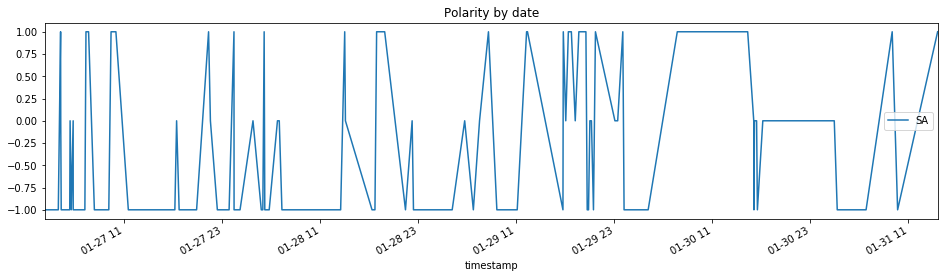

In [17]:
df.plot(x='timestamp', y='SA', figsize=(16,4), title='Polarity by date')

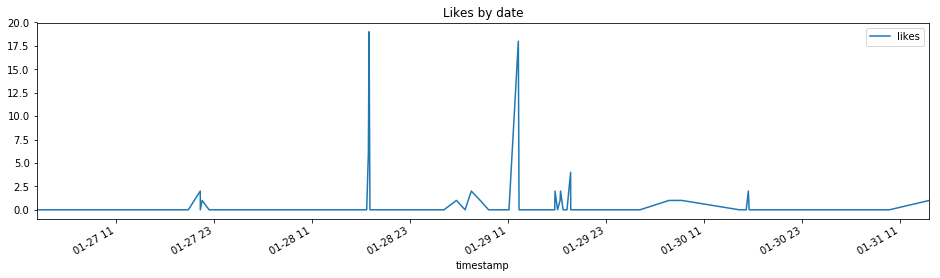

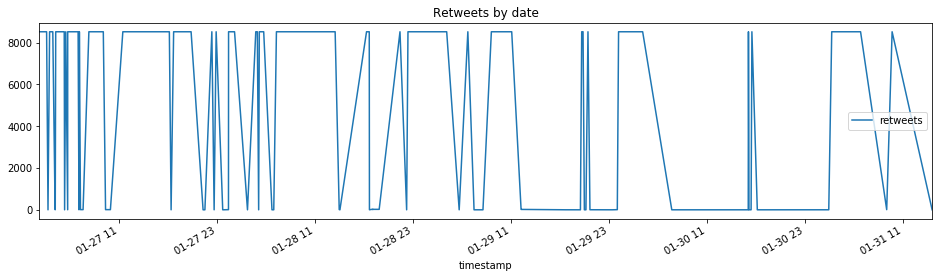

In [18]:
df.plot(x='timestamp', y='likes', figsize=(16,4), title='Likes by date')
df.plot(x='timestamp', y='retweets', figsize=(16,4), title='Retweets by date')

In [19]:
df.to_csv('C:\BTS_Master\AdvancedDataAnalysis\Session_5/twitter_homework.csv')

In [53]:
gdf = gpd.read_file('C:\BTS_Master\AdvancedDataAnalysis\Session_5/random_points_homework.shp')
gdf = gdf.to_crs({'init': 'epsg:4326'})

In [54]:
gdf.head()

,id,twitter_ho,twitter__1,twitter__2,twitter__3,twitter__4,twitter__5,twitter__6,twitter__7,twitter__8,xcoord,ycoord,geometry
0,0,Generate Over 12x the power of regular #Solar ...,106,2018-01-31 14:34:24,MrsaActionApp,1,1,None,2018-01-31 14:34:24,1,-119.041638,34.516202,POINT (-119.0416379024918 34.51620172763505)
1,1,RT @daxshepard1: I can not fathom being anti-r...,140,2018-01-31 09:40:29,Twitter Web Client,0,8517,None,2018-01-31 09:40:29,-1,-122.971272,40.935435,POINT (-122.9712720122364 40.93543454020763)
2,2,RT @uclaanderson: All 10 @UofCalifornia campus...,140,2018-01-31 09:00:42,Twitter for iPhone,0,7,None,2018-01-31 09:00:42,1,-116.772880,35.634928,POINT (-116.77287960268 35.63492797981905)
3,3,RT @daxshepard1: I can not fathom being anti-r...,140,2018-01-31 05:48:51,Twitter for iPhone,0,8517,None,2018-01-31 05:48:51,-1,-117.905103,33.969218,POINT (-117.9051030186767 33.96921761492283)
4,4,RT @daxshepard1: I can not fathom being anti-r...,140,2018-01-31 03:07:29,Twitter for iPhone,0,8517,None,2018-01-31 03:07:29,-1,-121.441036,37.551898,POINT (-121.4410364320383 37.55189834676901)


In [55]:
gdf.twitter__8 = gdf.twitter__8.astype(str)

In [56]:
positive_table = gdf[gdf['twitter__8'] == '1']
neutral_table = gdf[gdf['twitter__8'] == '0']
negative_table = gdf[gdf['twitter__8'] == '-1']

In [57]:
Twitter_map = folium.Map([34.0522342,-118.2436849], tiles='cartodbpositron', zoom_start = 5)
Twitter_map

In [58]:
locations_pos = positive_table[['ycoord', 'xcoord']].values.tolist()
locations_neut = neutral_table[['ycoord', 'xcoord']].values.tolist()
locations_neg = negative_table[['ycoord', 'xcoord']].values.tolist()

In [59]:
# reseting indexes to be able to plot
positive_table.reset_index(inplace=True)
neutral_table.reset_index(inplace=True)
negative_table.reset_index(inplace=True)

# converting likes to string for pop ups
positive_table.twitter__4 = positive_table.twitter__4.astype(str)
neutral_table.twitter__4 = neutral_table.twitter__4.astype(str)
negative_table.twitter__4 = negative_table.twitter__4.astype(str)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [60]:
for point in range(len(locations_pos)):
    folium.Marker(locations_pos[point], popup=positive_table['twitter__4'][point],
                  icon=folium.Icon(color='green', icon_color='white', icon='male', angle=0, prefix='fa')).add_to(Twitter_map) #You can use different fonts such as "bicycle", "info-sign", "cloud".

for point in range(len(locations_neut)):
    folium.Marker(locations_neut[point], popup=neutral_table['twitter__4'][point],
                  icon=folium.Icon(color='darkblue', icon_color='white', icon='male', angle=0, prefix='fa')).add_to(Twitter_map)

for point in range(len(locations_neg)):
    folium.Marker(locations_neg[point], popup=negative_table['twitter__4'][point],
                  icon=folium.Icon(color='red', icon_color='white', icon='male', angle=0, prefix='fa')).add_to(Twitter_map)

Twitter_map

In [62]:
Twitter_map.save('C:\BTS_Master\AdvancedDataAnalysis\Session_5/Twitter_map.html')